# TransC Ensemble Sampler applied to AEM Lagrange dataset - single layered model

This example demonstrates the use of the Trans-C Ensemble Sampler on a real Airborne EM dataset and compares results to a Trans_D sampler.

### Problem setup

The Earth model is a layered 1D profile of log conductivities.

    - 10 independent states are used such that state n has n layers with variable layer thickness.
    - Posterior ensembles of models are read in and sampled over with the Ensemble sampler.
    - Results are comparedto a Reversible-Jump solution produced by Ross Brodie's code (https://github.com/GeoscienceAustralia/ga-aem)

In [1]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import arviz as az
import random
from tqdm import tqdm
from functools import partial
from PIL import Image
from IPython.display import display
from utils.AEM_IO_utils import *

#### TransC class

In [2]:
from pyTransC import TransC_Sampler

#### Read ensembles for each state

Here we read in 25000 posterior samples for each of the 10 states, together with their log-posterior values (unnormalized). These were prepared using an MCMC sampler applied separately to each state.

In [3]:
# read in enembles
#ensemble_per_state, log_posterior_ens, nstates, ndims, nens = read_aem_ensembles(convert_to_thicknesses=True)
ensemble_per_state, log_posterior_ens, nstates, ndims, nens = read_aem_ensembles("AEM_data")
print('Number of states: ',nstates)
print('Size of ensemble in each state',nens)
print('Number of parameters in each state',ndims)
bounds = [0,500, 0.001,5.0] # parameter bounds (zmin,zmax,logc_min,logc_max)

Number of states:  10
Size of ensemble in each state 25000
Number of parameters in each state [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]


#### Plot input ensembles for reference

We take a quick look at the input ensembles of models witha  corner plot. 

Here we plot the 5th ensemble which has 5 layers, with 4 interface depths and 5 conductivities. 

In [4]:
azdata = create_InferenceData_object(ensemble_per_state,log_posterior_ens,log_likelihood=None) # create list of arviz objetcs to help with plotting

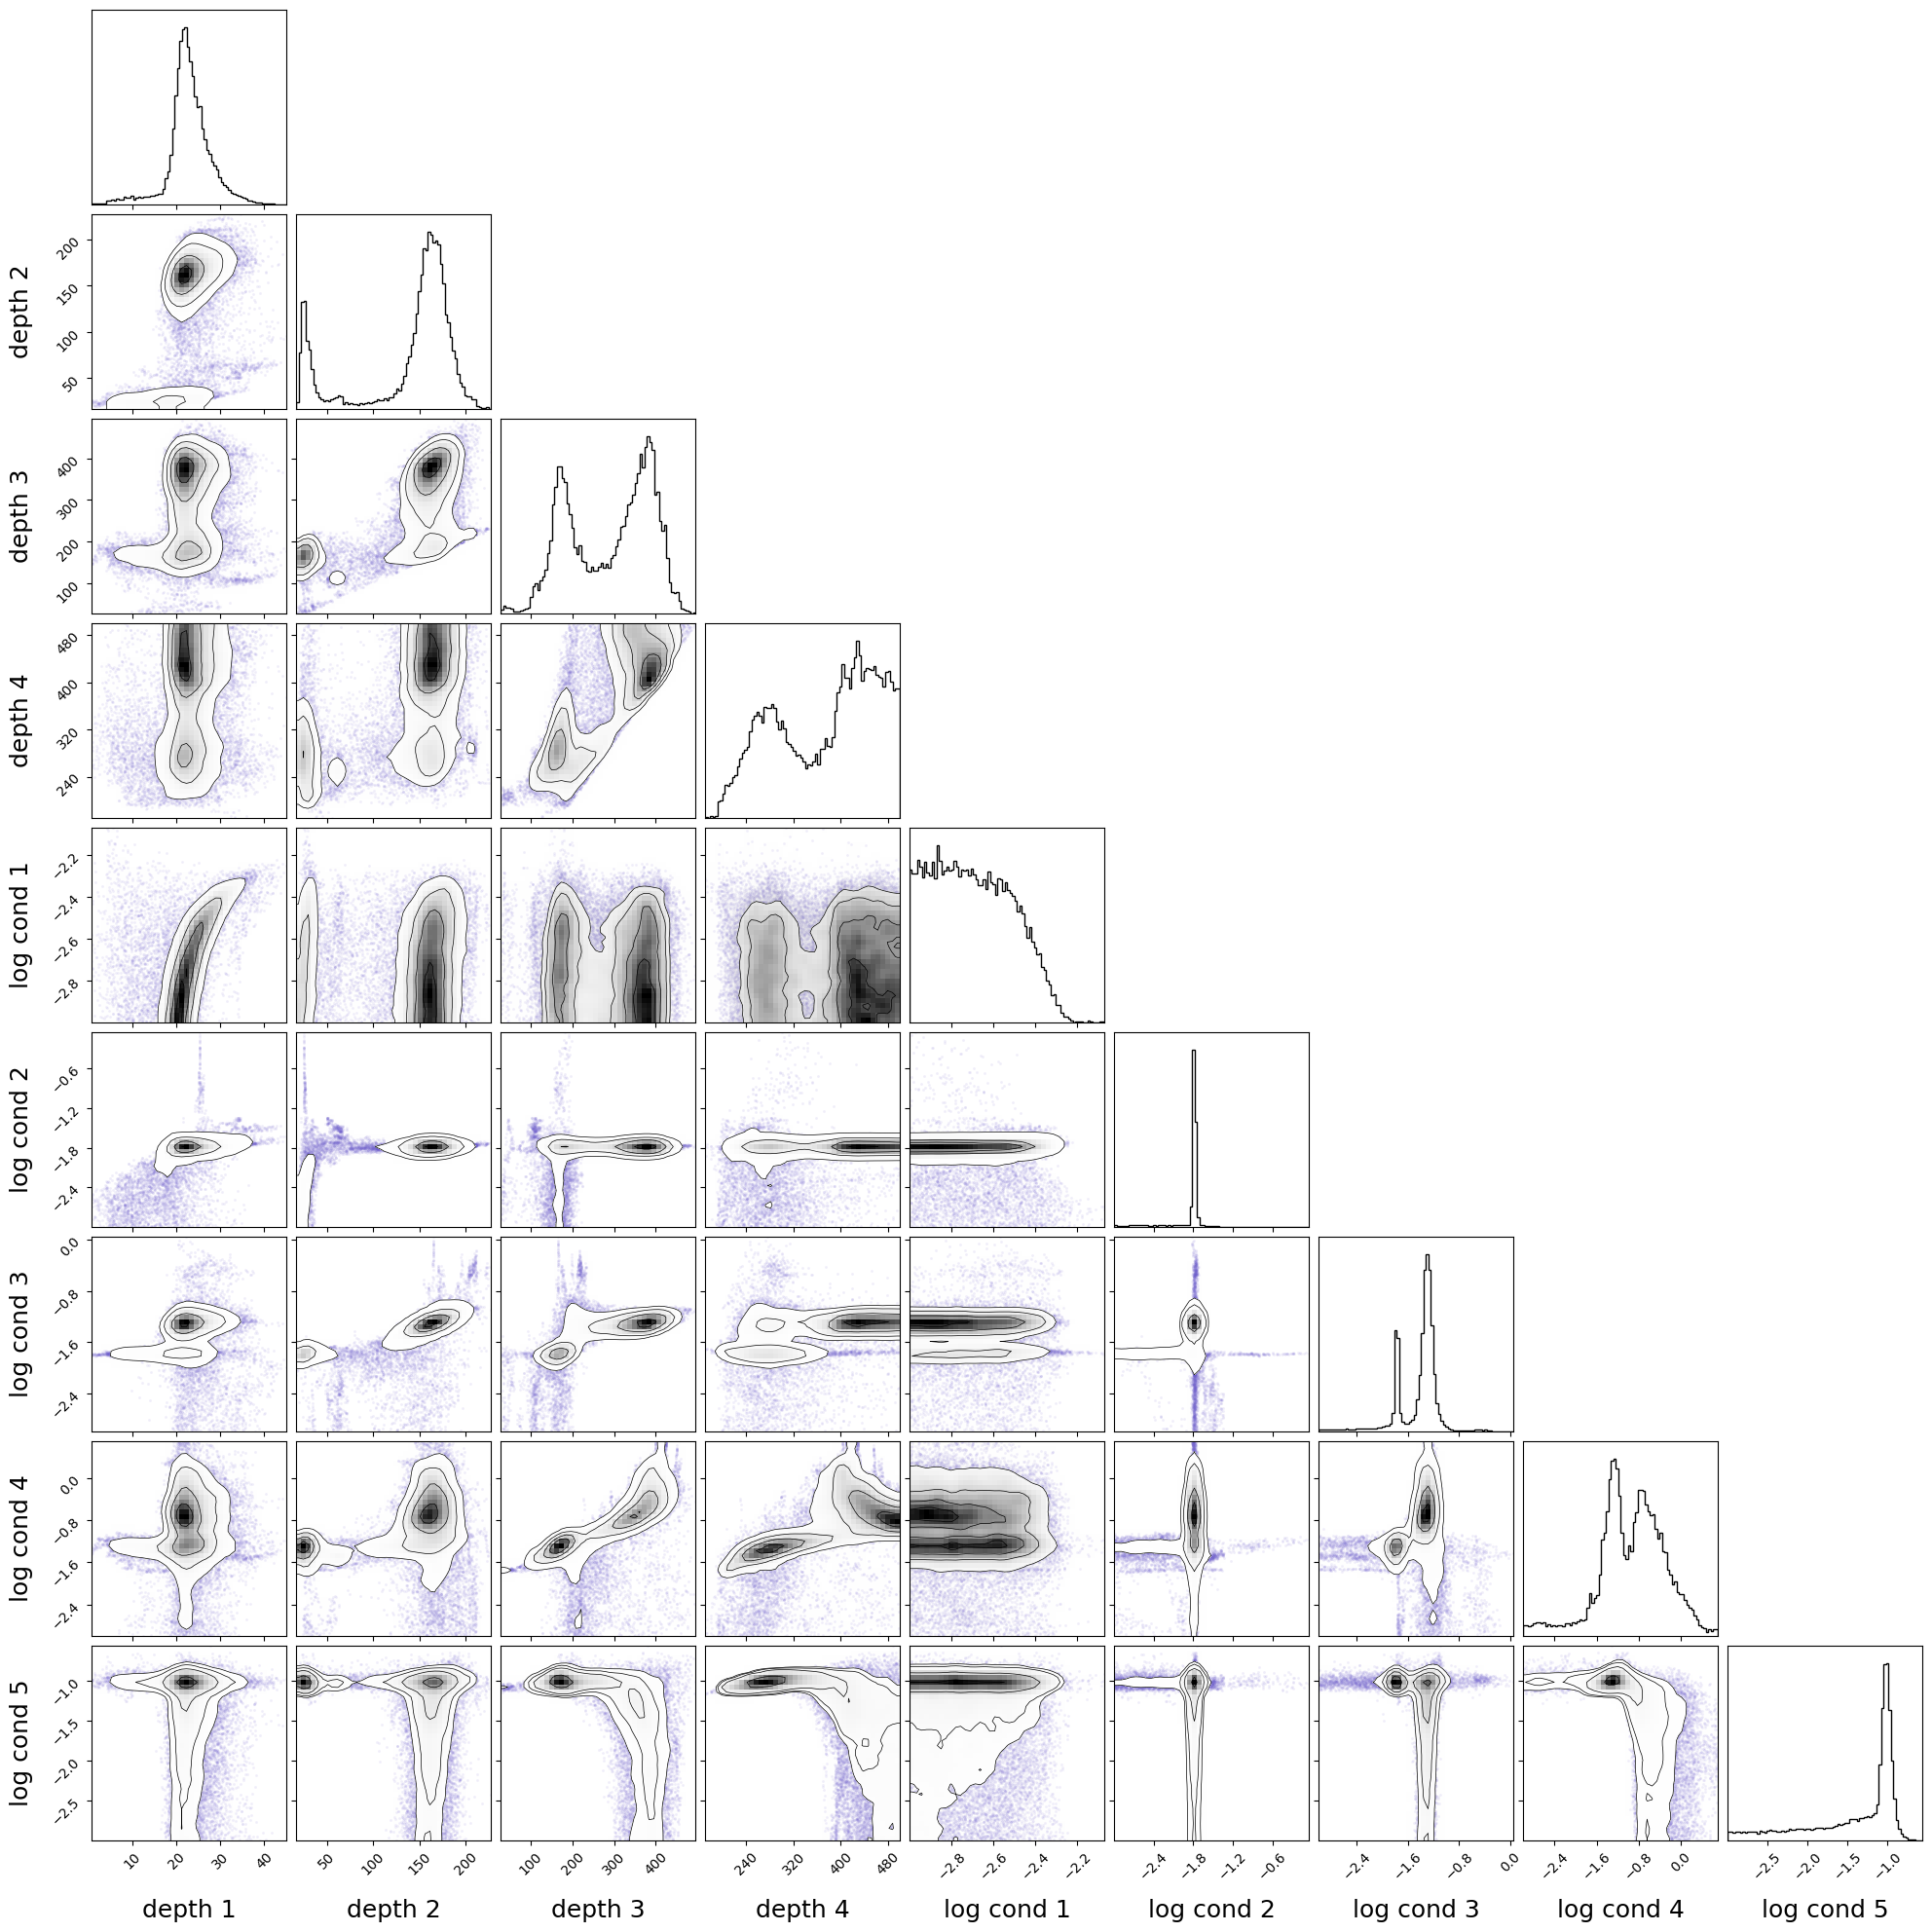

In [5]:
state = 4
label_kwargs = {"fontsize" : 18}
plot_ensembles(azdata[state],traceplot=False,label_kwargs=label_kwargs) # corner plot and traceplot of input ensemble in selected state

The posterior ensembles look to have some non-Gaussian structure.

#### Initialize TransC Sampler

In [6]:
# perform initiation of IS-sampler
tcs_ens = TransC_Sampler(nstates,ndims) # create instances of states

#### Build pseudo priors

Since it appears that for this input ensemble the prior is omitted then implictely by setting the pseudo prior density to unity we are effectively equating the pseudo prior with the actual prior.

In [7]:
# create pseudo prior function and evaluate for all ensembles
pseudoprior = 'fit'      # fit a Gaussian mixture model to each state to get a normalized pseudo prior PDF.
pseudoprior = 'uniform'  # pseudo prior function has layers defined by uniform random interfaces in depth and uniform random log c between bounds.
if(pseudoprior == 'fit'):  
    
    auto_log_pseudo_prior,log_pseudo_prior_ens = tcs_ens.auto_pseudo_prior(None,None,verbose=True,
                                                                          ensemble_per_state=ensemble_per_state,log_posterior_ens=log_posterior_ens,
                                                                          return_log_pseudo=True,progress=True,reg_covar=1E-15,n_components=2)
else: # we define the pseudo_prior ourselves
        
    def log_pseudo_prior(x,state,ndims,bounds,returndeviate=False):  

        ncond = ndims[state]-state # number of conductivities
        ndepths = state            # number of interfaces

        if(returndeviate):
            ncond = ndims[state]-state  # number of conductivities
            ndepth = state             # number of interfaces
            zmin,zmax,logcmin,logcmax = bounds
            z = np.sort(zmin + (zmax-zmin)*np.random.rand(ndepth))
            logc = logcmin + (logcmax-logcmin)*np.random.rand(ncond)
            if(state == 0):
                x = logc
            else:
                x = np.hstack((z,logc)) 
            return 0.,x
        else:
            if(x.ndim == 1): return np.zeros(len(x)) # log(1)
            if(x.ndim == 2): return np.zeros(np.shape(x)[0]) # log(1)
           
    log_pseudo_prior_ens = []
    for state in tqdm(range(nstates)): # build pseudo prior ensemble
        a = log_pseudo_prior(ensemble_per_state[state],state,ndims,bounds)
        log_pseudo_prior_ens.append(a)
        auto_log_pseudo_prior = partial(log_pseudo_prior,bounds=bounds,ndims=ndims)


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 42930.44it/s]


Now we generate samples from the pseudo_prior and take a look at them, for the same state as above.

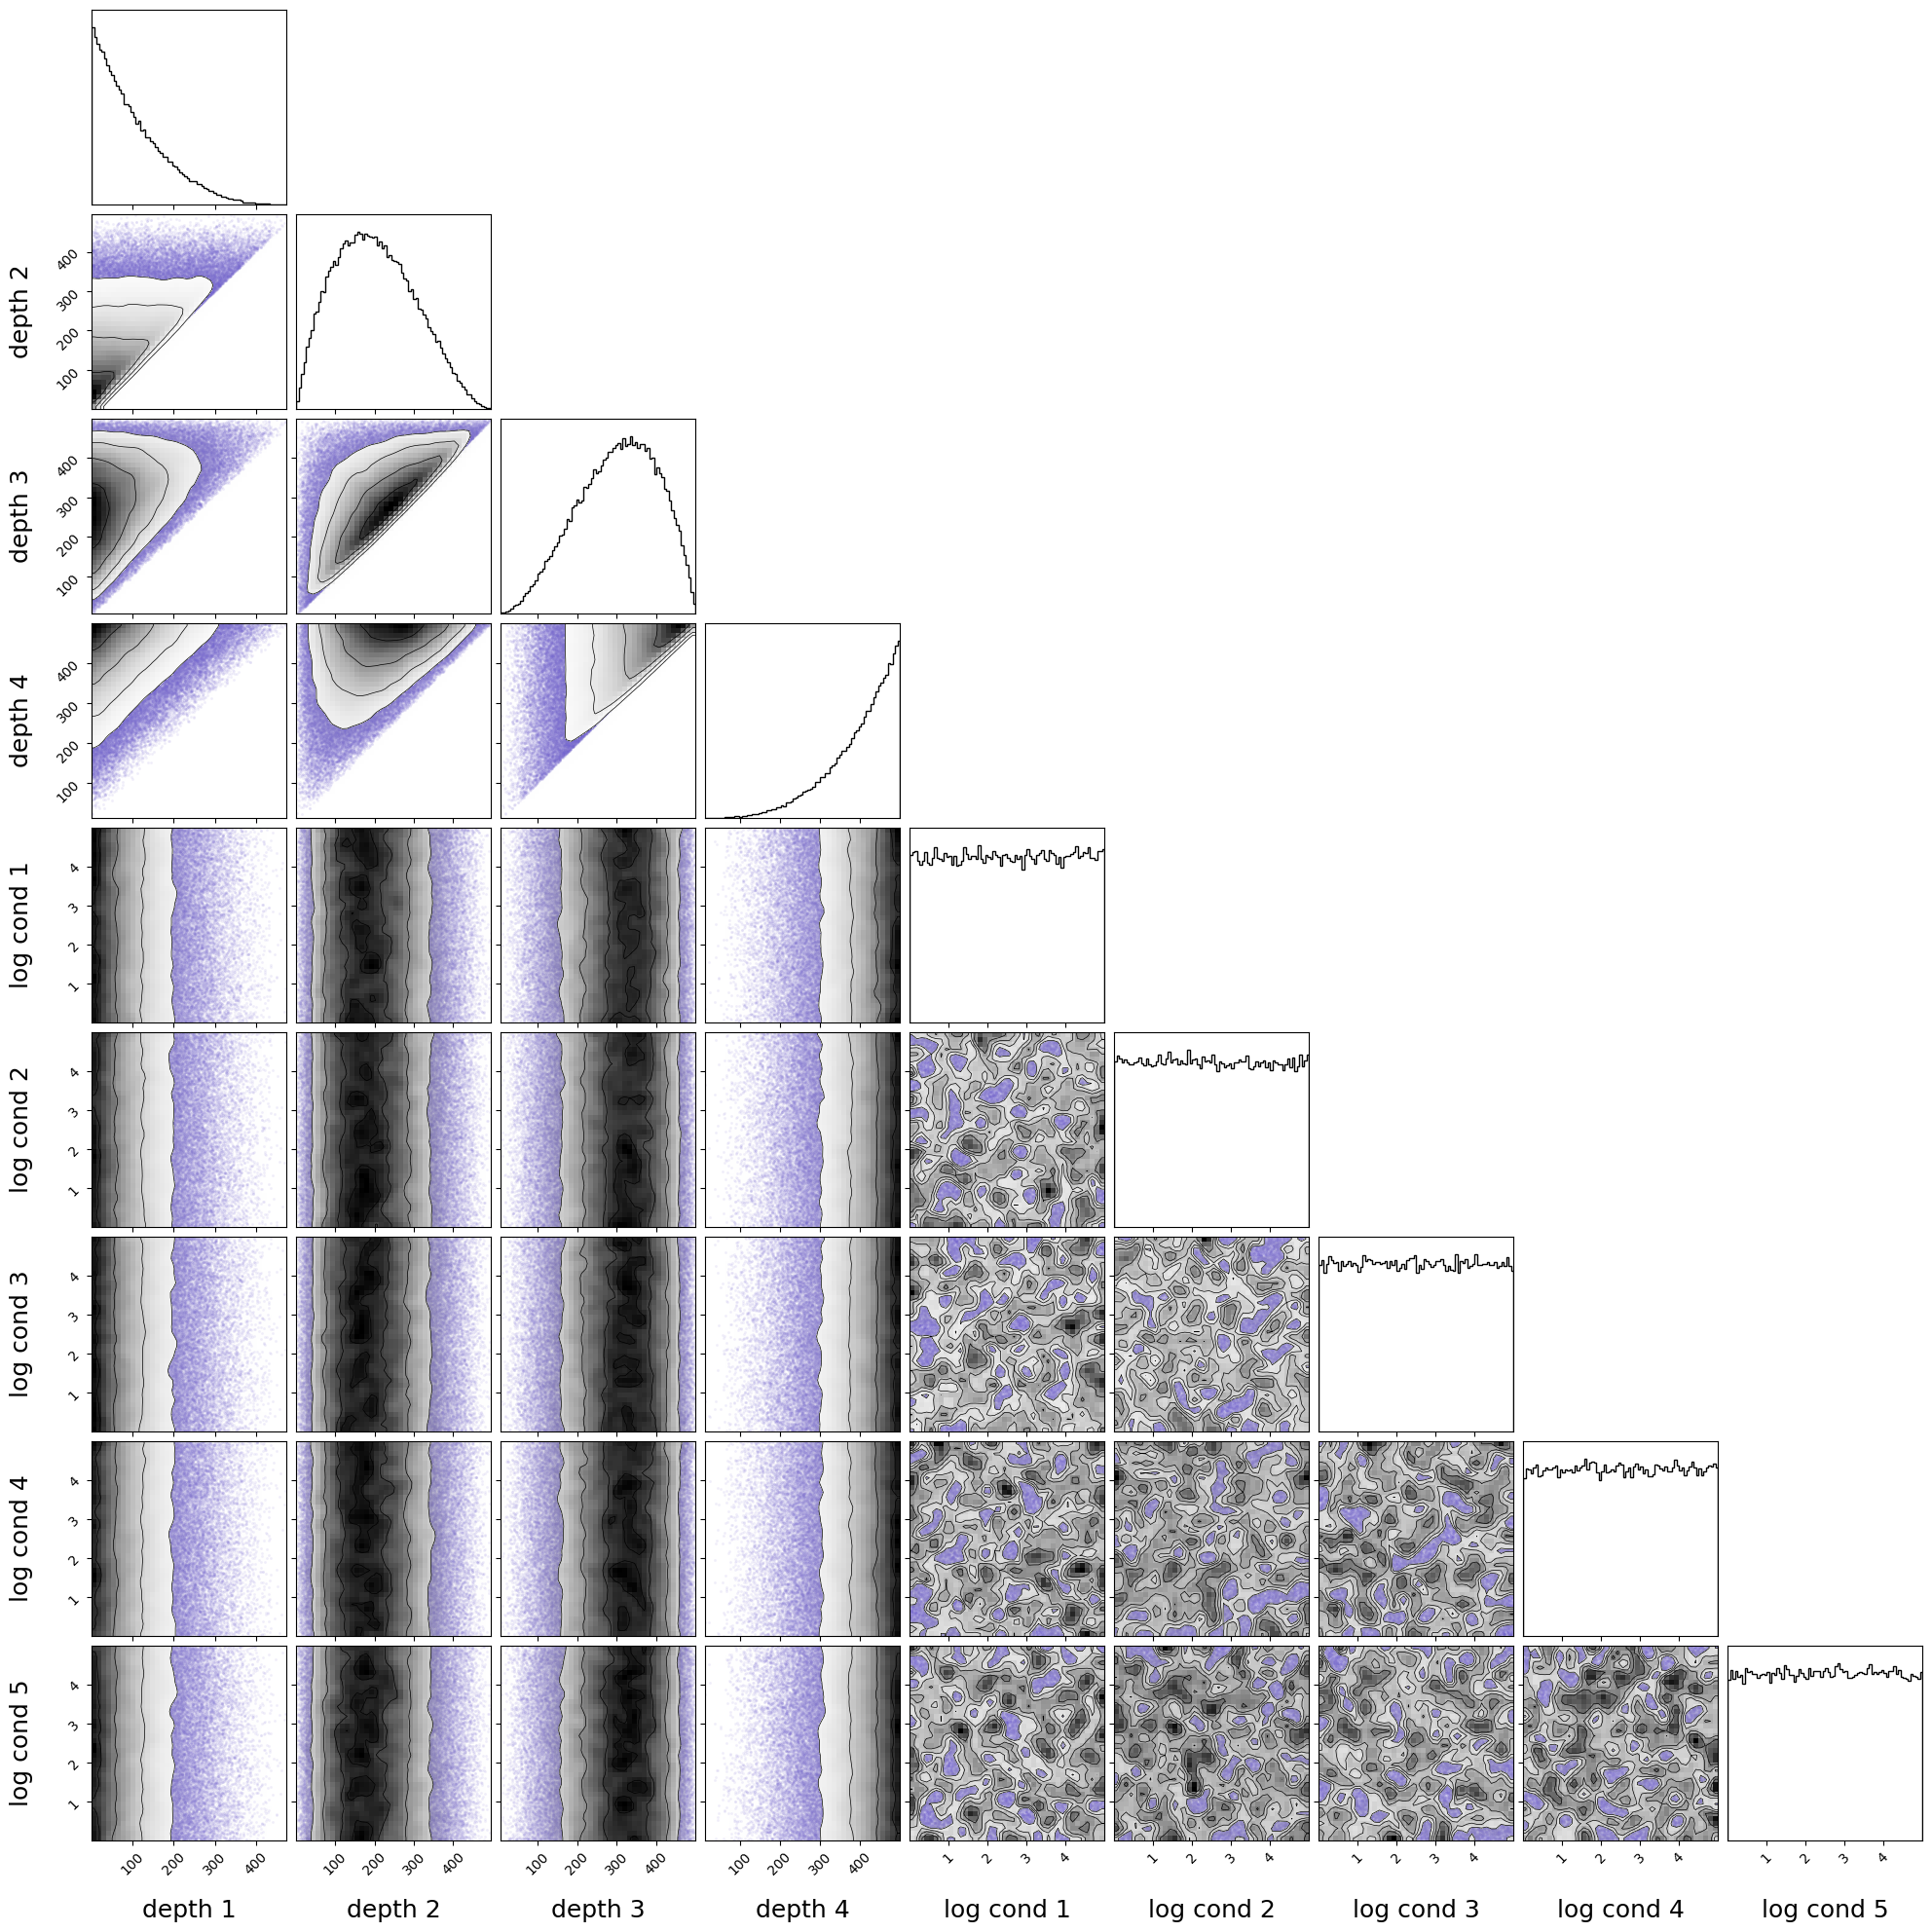

In [8]:
state = 4
label_kwargs = {"fontsize" : 18}
plot_pseudo_samples(auto_log_pseudo_prior,state,ndims,ns=100000,truths=None,params=None,filename='IS_priorsamples_corner_'+str(state)+'.pdf',label_kwargs=label_kwargs) # generates and plots samples from the pseudo_prior generating function 

While the prior distribution of interface depths is uniform, here they are labelled in ranked order, and so the samples for each state become conditional on each other. 

Hence when samples pairs are plotted they are restricted to the triangular region $z_{i+1} > z_i$, and we see the effect above.

All layer conductivity priors are uniform. 

#### Run Ensemble Sampler across states

In [9]:
# Calculate marginal Likelihoods using ensembles for each state
nwalkers = 32   # number of independent random walkers across ensembles
nsteps = 500000 # number of chain steps for each walker
start_time = time.time()
stateproposalweights = setproposalweights(nstates,-1) # set the number of neighbour states to focus transition proposals (-1 gives equal transition probability between all states)
result = tcs_ens.run_ensemble_sampler(nwalkers,nsteps,progress=True,parallel=False, 
                                      log_posterior_ens=log_posterior_ens, 
                                      log_pseudo_prior_ens=log_pseudo_prior_ens,
                                      stateproposalweights=stateproposalweights) # run mcmc sampler over ensembles to get marginal Likelihoods between states
elapsed_time = time.time() - start_time


Running ensemble trans-D sampler

Number of walkers               :  32
Number of states being sampled  :  10
Dimensions of each state        :  [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [02:26<00:00,  4.59s/it]


#### Diagnostics

In [10]:
chain,states_chain = ens_diagnostics(tcs_ens,elapsed_time)


 Algorithm type                                      : TransC-ensemble-sampler
 Number of walkers                                   : 32
 Number of steps                                     : 500000
 Average % acceptance rate for between states        : 21.62
 Auto correlation time for between state sampling    : 8.89053
 Total number of state changes for all walkers       : 827623
 Estimated relative evidences ens                    : 0.0 0.0 0.00098 0.03873 0.09427 0.12215 0.17119 0.1886 0.19148 0.19261
 Elapsed time                                        : 146.8 s 



### Time spent in each state

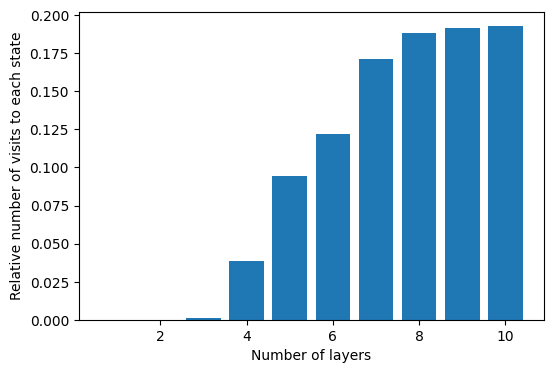

In [11]:
matplotlib.pyplot.figure(figsize=(6,4))
matplotlib.pyplot.bar(np.arange(11)[1:],tcs_ens.relative_marginal_likelihoods)
matplotlib.pyplot.xlabel('Number of layers')
matplotlib.pyplot.ylabel('Relative number of visits to each state')
matplotlib.pyplot.savefig('IS_posterior_histogram_10.pdf')
matplotlib.pyplot.show()

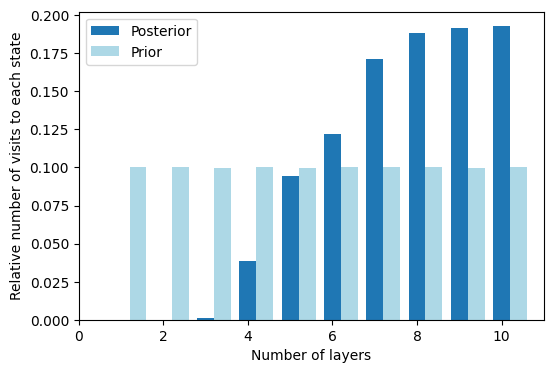

In [12]:
# here is a result prepared earlier apply the Trans_C sampler to the uniform prior for comparison
visits_prior = np.array([0.10008 ,0.10004 ,0.09992 ,0.10004 ,0.09994 ,0.10003 ,0.10004 ,0.10004 ,0.09992 ,0.09996])
figsize = (6,4)
plotpair,width=True,0.4
fig = matplotlib.pyplot.figure(figsize=figsize)
if(plotpair):
    matplotlib.pyplot.bar(np.arange(11)[1:],tcs_ens.relative_marginal_likelihoods,width=width,label='Posterior')
    matplotlib.pyplot.bar(np.arange(11)[1:]+width,visits_prior,width=width,label='Prior',color='lightblue')
else:
    width=0.8
    matplotlib.pyplot.bar(np.arange(11)[1:],tcs_ens.relative_marginal_likelihoods,width=width,label='Posterior')
    
ax = fig.gca()
matplotlib.pyplot.xlabel('Number of layers')
matplotlib.pyplot.xlim((0,11))
matplotlib.pyplot.ylabel('Relative number of visits to each state')
matplotlib.pyplot.legend()
#matplotlib.pyplot.savefig(filename)
matplotlib.pyplot.show()

A plot of the posterior sampling over states compared to the uniform prior.

#### Generate a trans-D ensemble

Here we generate a ensemble across the states from the Ensemble Sampler and compare the model density to a previously run Trans-D code using reversible-jump MCMC.

In [13]:
transd_ensemble,model_chain,states_chain = tcs_ens.get_transc_samples(100000,ensemble_per_state=ensemble_per_state,returnchains=True)# generate order trans-D ensemble

In [14]:
# fancy density plot properties
pcentiles = [[10,50,90],       # percentile curves to plot on top of density plot
             ['r','c','r'],    # colours of percentile curves
             [0.4,0.6,0.4]]    # line widths of percentile curves
pcentiles = [[50],       # percentile curves to plot on top of density plot
             ['c'],    # colours of percentile curves
             [1.0]]    # line widths of percentile curves
interfaceplotcolor = 'C0'      # add an interface density plot with this colour of fill
cmap = 'gray_r'                # colour map of density plot
log = True                     # use log(density) for colour map (T/F)
density_cutoff = 2             # relative density percentage below which to white out (makes plot prettier) 

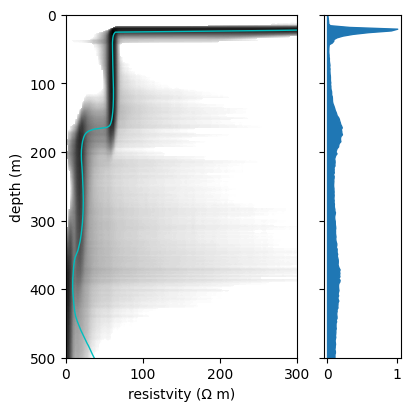

In [15]:
den = plot_histogram_is(transd_ensemble,0,300,100,0,500,200,              # fancy density plot
                           figsize=(4,4),
                           cmap=cmap,log=log,
                           density_cutoff=density_cutoff,
                           pcentiles=pcentiles, 
                           interfaceplotcolor=interfaceplotcolor,filename='IS_densityprofile_10_nomean.pdf')

Here is the result using Reversible-Jump MCMC found with [Ross Brodie's Reversible-Jump MCMC code](https://github.com/GeoscienceAustralia/ga-aem)

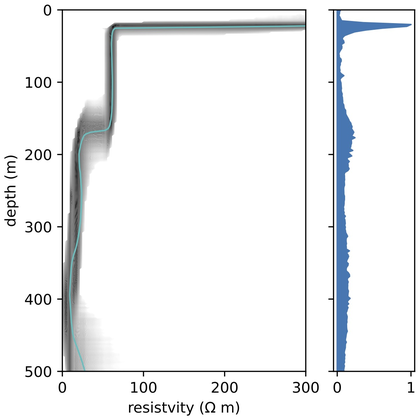

In [17]:
img = Image.open("./AEM_data/rjmcmc_densityprofile.jpg")
display(img.resize((420, 420), Image.LANCZOS))

The two solutions are very similar.